## Datapreprocessing Methods observed in papers

In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def loadImage(filename, gray=False):
    
    plt.title("Loaded Image");
    
    if(gray):
        img = cv2.imread(filename,0)
        plt.imshow(img, cmap='gray')
    else:
        img = cv2.imread(filename)
        plt.imshow(img)
        
    return img

def applyClahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    claheimg = clahe.apply(img)
    plt.title("CLAHE on Greenscale Image")
    plt.imshow(claheimg,cmap='gray')
    
    return claheimg

def greenChannel(img):
    greenImage = img[:,:,1]
    
    plt.title("Green Channel Image")

    plt.imshow(greenImage, cmap='gray')
    
    return greenImage
    

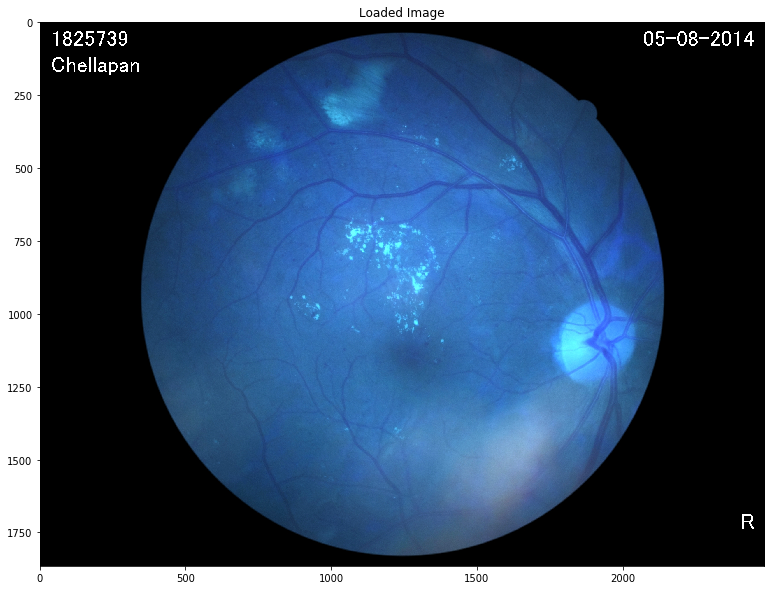

In [29]:
#Sample Preprocessing clahe vs green, 
plt.rcParams["figure.figsize"] = (25,10)
img = loadImage("image2.jpg")
plt.imshow(img)

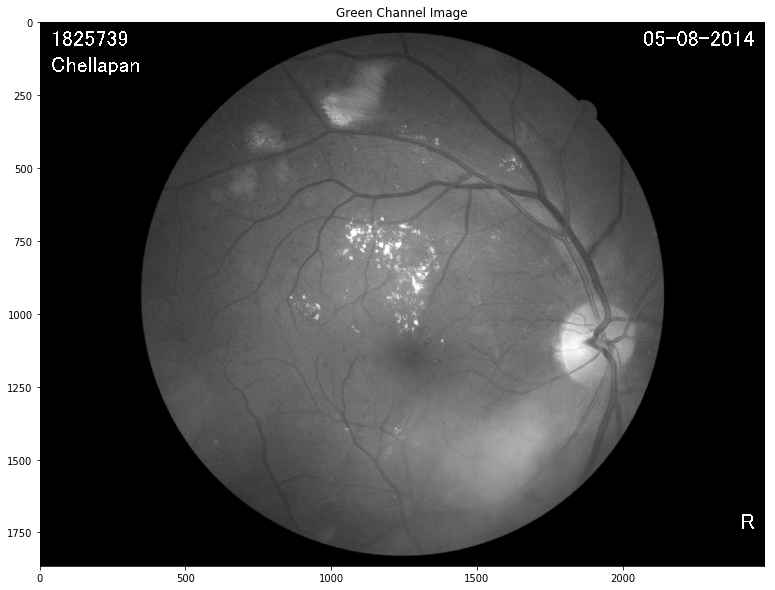

In [31]:
greenImage = greenChannel(img)

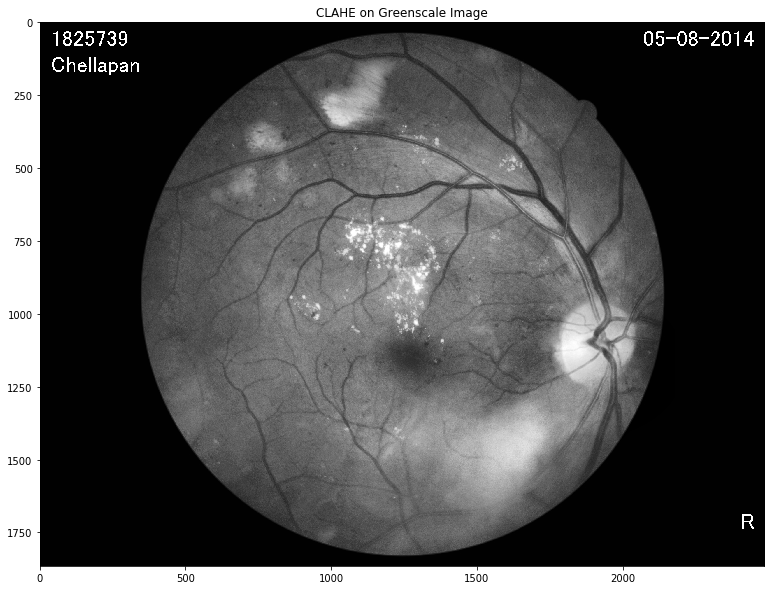

In [32]:
claheImage = applyClahe(greenImage)

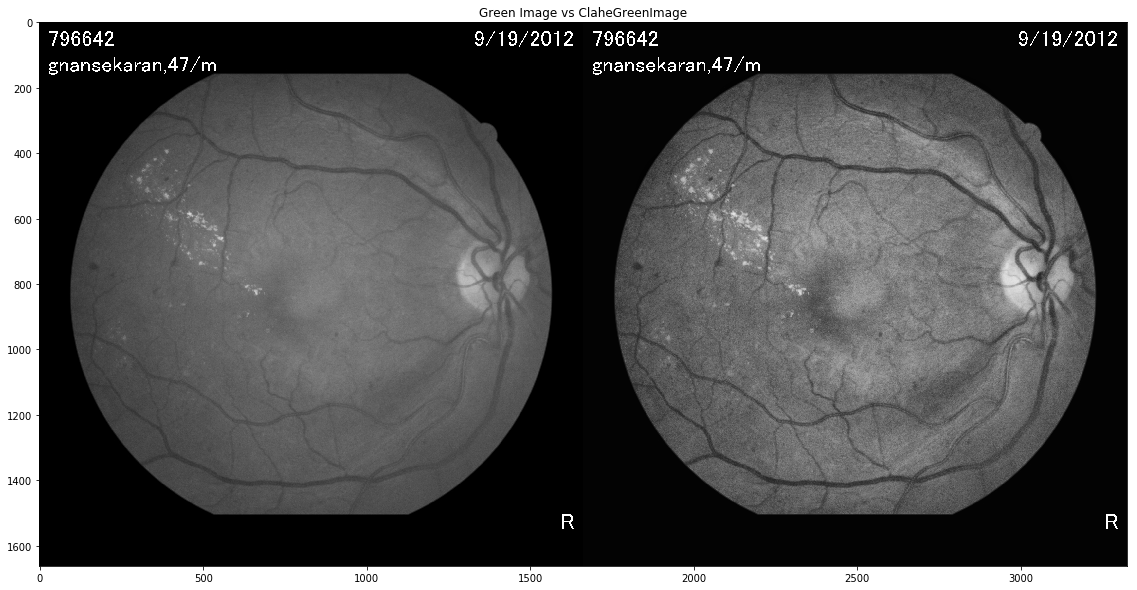

In [73]:
result = np.hstack((greenImage, claheImage))
plt.rcParams["figure.figsize"] = (25,10)
plt.title("Green Image vs ClaheGreenImage")
plt.imshow(result, cmap='gray')

## Extracting Blood Vessels

In [74]:
def extract_bv(image):
    
        import cv2 as cv2
        
        b,green_fundus,r = cv2.split(image)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        contrast_enhanced_green_fundus = clahe.apply(green_fundus)

        # applying alternate sequential filtering (3 times closing opening)
        r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
        R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
        r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
        R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
        r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
        R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
        f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
        f5 = clahe.apply(f4)

        # removing very small contours through area parameter noise removal
        ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
        mask = np.ones(f5.shape[:2], dtype="uint8") * 255
        im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) <= 200:
                cv2.drawContours(mask, [cnt], -1, 0, -1)
        im = cv2.bitwise_and(f5, f5, mask=mask)
        ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)
        newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)

        # removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
        #vessels and also in an interval of area
        fundus_eroded = cv2.bitwise_not(newfin)	
        xmask = np.ones(fundus_eroded.shape[:2], dtype="uint8") * 255
        x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        for cnt in xcontours:
            shape = "unidentified"
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   
            if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
                shape = "circle"
            else:
                shape = "veins"
            if(shape=="circle"):
                cv2.drawContours(xmask, [cnt], -1, 0, -1)

        finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
        blood_vessels = cv2.bitwise_not(finimage)
        
        plt.title("Extracted Blood Vessels from RGB Image")
        plt.rcParams["figure.figsize"] = (25,10)
        plt.imshow(blood_vessels, cmap='gray')
        return blood_vessels

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

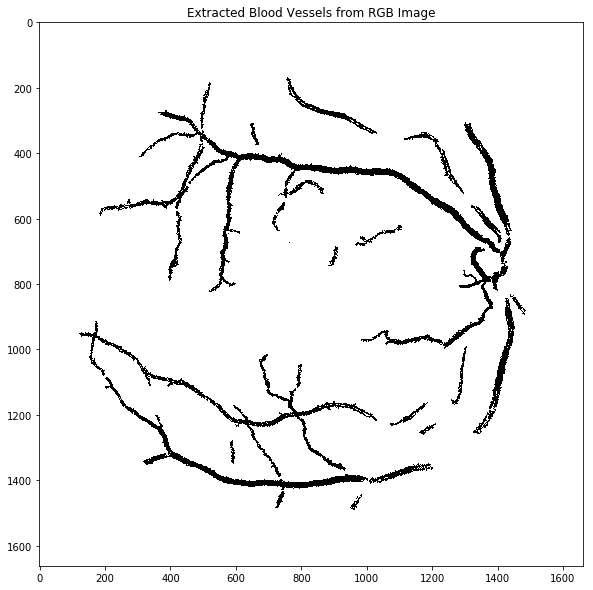

In [75]:
extract_bv(img)

## Extracting Exudates

In [76]:
#https://github.com/ebdulrasheed/Diabetic-Retinopathy-Feature-Extraction-using-Fundus-Images/blob/master/Exudates.py

class ExtractExudates:
    
    jpegImg = 0
    grayImg = 0
    curImg = 0

    def setImage(self, img):
        self.jpegImg = img
        self.curImg = np.array(img)    ##Convert jpegFile to numpy array (Required for CV2)

    def getImage(self):
        return self.curImg
        
    def greenComp(self):
    ###Extracting Green Component
        self.curImg = greenChannel(self.curImg)

    def applyCLAHE(self):
    #Applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
        self.curImg = applyClahe(self.curImg)
        
# create a CLAHE object (Arguments are optional).
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#claheImg = clahe.apply(clImg)
#cv2.imwrite('clahe_2.jpg',claheImg)

    def applyDilation(self):
        #Creating Structurig Element
        strEl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
        #Dilation
        dilateImg = cv2.dilate(self.curImg, strEl)
        self.curImg = dilateImg

    def applyThreshold(self):
        #Thresholding with Complement/Inverse
        retValue, threshImg = cv2.threshold(self.curImg, 170, 255, cv2.THRESH_BINARY) #Change this to your convenience
        self.curImg = threshImg

    def applyMedianFilter(self):
        #Median Filtering
        medianImg = cv2.medianBlur(self.curImg,5)
        self.curImg = medianImg

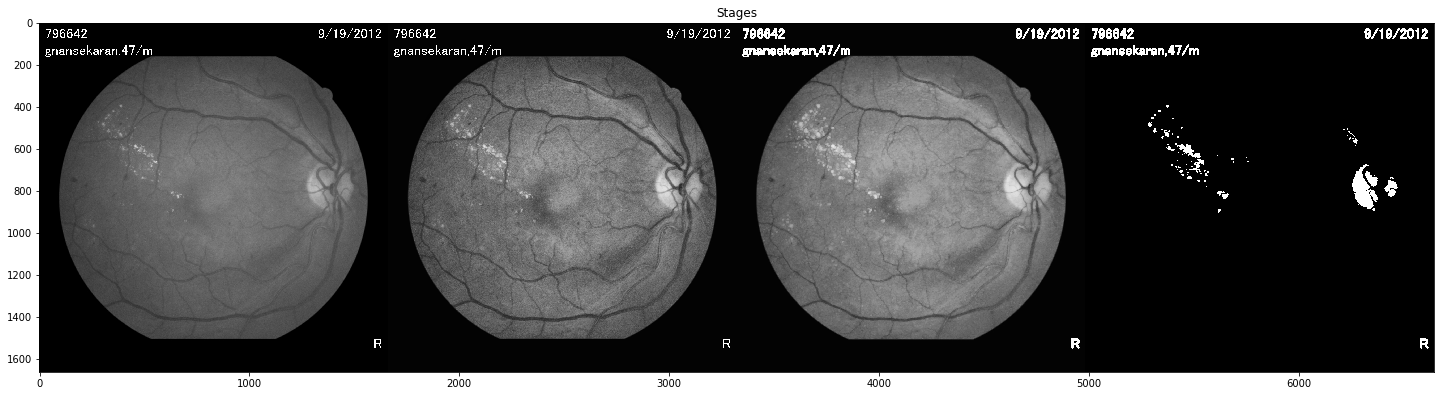

In [77]:
e = ExtractExudates()

e.setImage(img)

e.greenComp()
i1 = e.getImage()
e.applyCLAHE()

i2 = e.getImage()
e.applyDilation()

i3 = e.getImage()
e.applyThreshold()

i4 = e.getImage()
e.applyMedianFilter()

i5 = e.getImage()

res = np.hstack((i1,i2,i3,i4))

plt.title("Stages")
plt.imshow(res, cmap='gray')


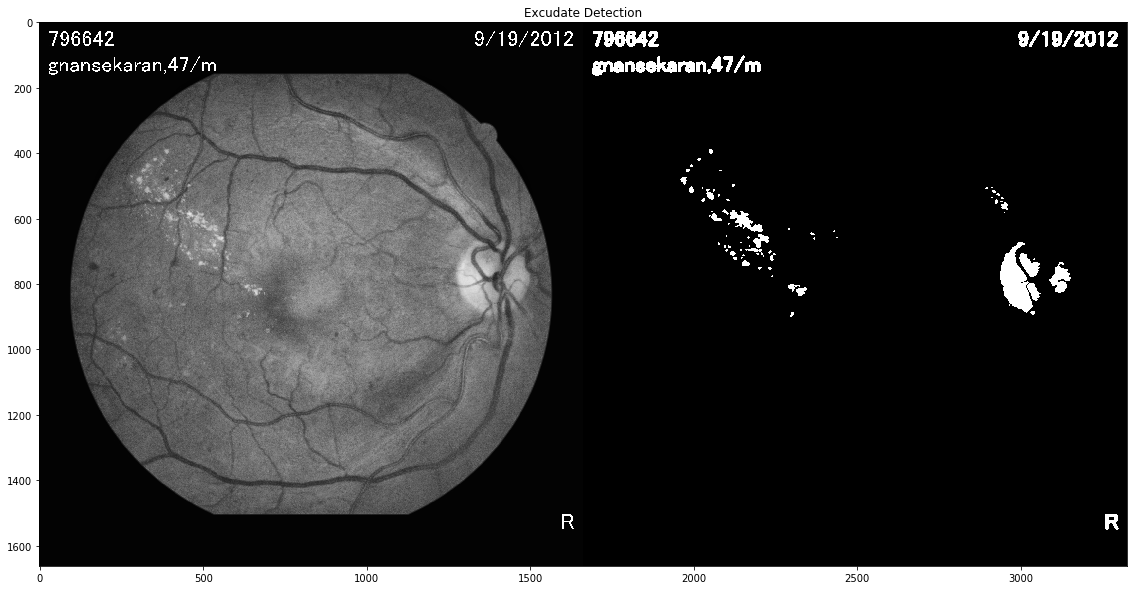

In [78]:
res = np.hstack((i2,i5))
plt.title("Excudate Detection")
plt.rcParams["figure.figsize"] = (25,15)
plt.imshow(res, cmap='gray')


## Removing LightGlares

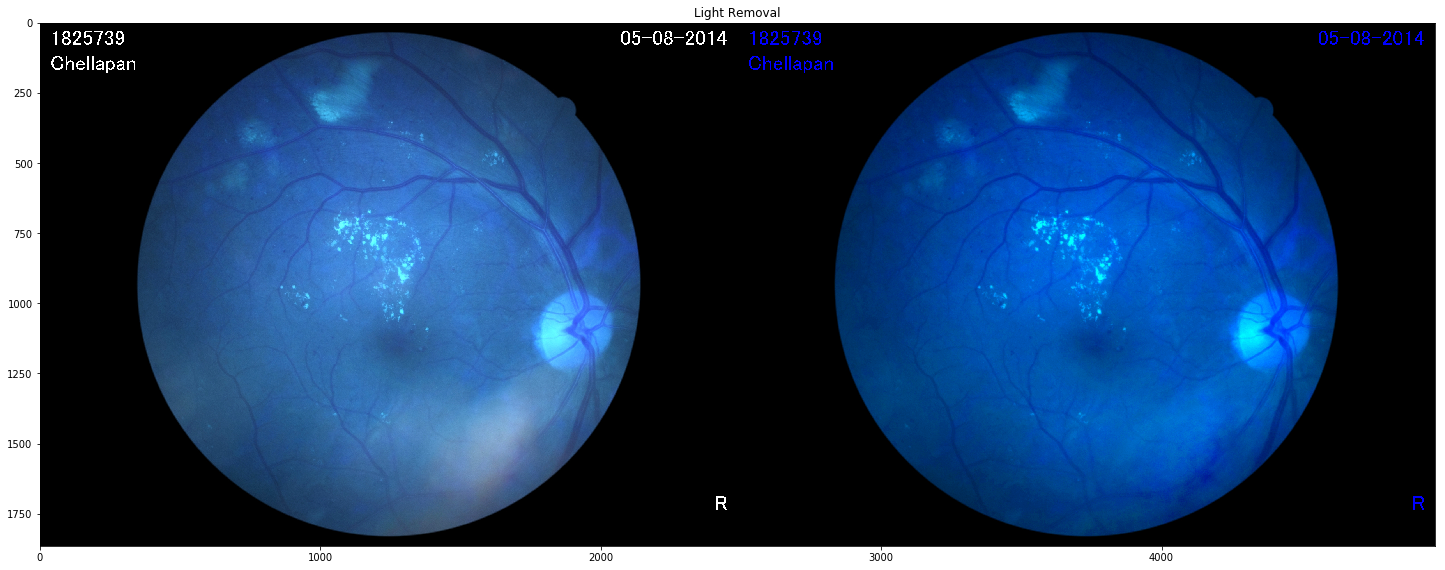

In [80]:
def removeLight(img):
    frame = img

    if frame is None:
        print('Error loading image')
        exit()    

    rows = frame.shape[0]
    cols = frame.shape[1]

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV);

    for i in range(0, cols):
        for j in range(0, rows):
            hsv[j, i][1] = 255;

    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR);
    
    return frame

img = loadImage("image2.jpg")
Better_img = removeLight(img)

res = np.hstack((img, Better_img))
plt.title("Light Removal")
plt.rcParams["figure.figsize"] = (25,15)
plt.imshow(res, cmap='gray')